# Exploring Univariate Series

There are several standard ways to explore univariate timeseries in order to understand it's behaviour and identify suitable ways for forecasting that data

In [2]:
# Load some data
%run setup.py

In [3]:
train.head()

,pickup_date,total_rides,total_takings
0,2013-08-01,307272,4.567414e+06
1,2013-08-02,236761,3.534616e+06
2,2013-08-03,226554,3.182267e+06
3,2013-08-04,202310,3.073609e+06
4,2013-08-05,406487,6.657713e+06


Lets manually add periodicity to the dataset 

In [77]:
#period_idx = pd.period_range(start=min(train['pickup_date']), end=max(train['pickup_date']), freq='D')

In [81]:
# Pull out series of interest
Exploration_series = train['total_rides']
Exploration_series.index = train['pickup_date']
Exploration_series.sort_index(inplace=True)
Exploration_series = Exploration_series.asfreq('D')

## View

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

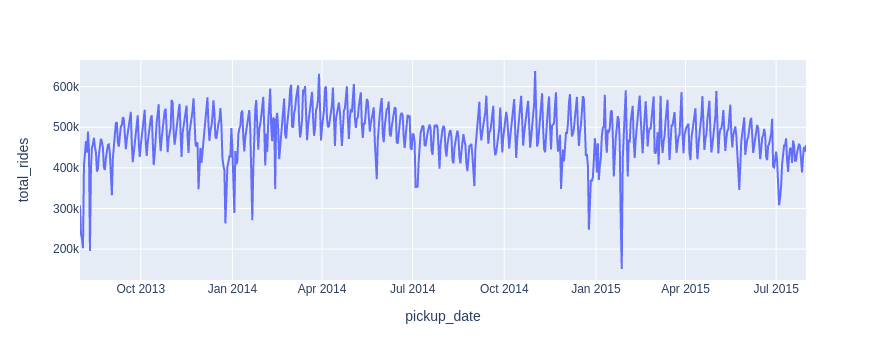

In [83]:
# Using plotly.express
import plotly.express as px

fig = px.line(Exploration_series, x=Exploration_series.index, y="total_rides")
fig.show()

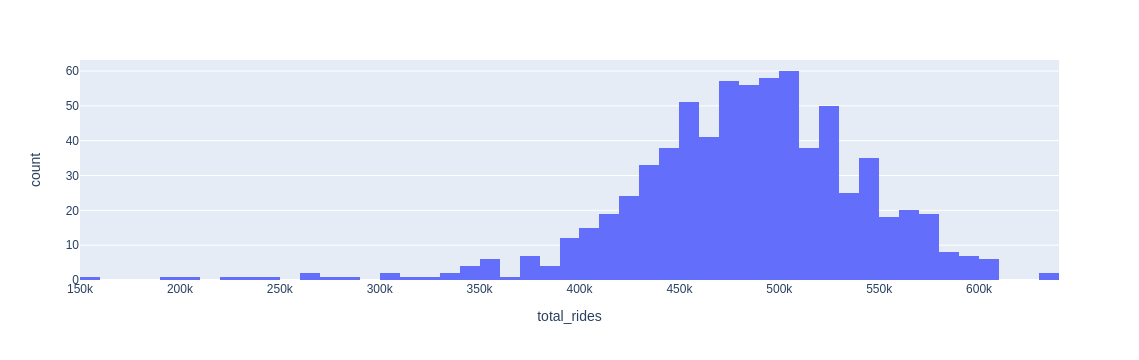

In [109]:
fig = px.histogram(Exploration_series, x="total_rides")
fig.show()

## Stationarity

In [85]:
def pretty_adfuller(ad_test):
    print("test statistic {0}".format(ad_test[0]))
    print("p-value {0}".format(ad_test[1]))
    print("num lags used in test {0}".format(ad_test[2]))
    print("critical values {0}".format(ad_test[3]))
    print("Maximised Information Criterion {0}".format(ad_test[4]))
    
    if ad_test[1] < 0.06:
        print()
        print("Reject the null hypothesis data is likely stationary")

In [86]:
from statsmodels.tsa.stattools import adfuller

In [89]:
#pretty_adfuller(adfuller(train['total_rides']))
pretty_adfuller(adfuller(Exploration_series))

test statistic -3.6949370597328675
p-value 0.004184935159348303
num lags used in test 20
critical values 709
Maximised Information Criterion {'1%': -3.439606888036868, '5%': -2.865625121924057, '10%': -2.5689454046801052}

Reject the null hypothesis data is likely stationary


In [43]:
from statsmodels.tsa.stattools import kpss

In [45]:
def pretty_kpss(kpss_test):
    print("Test-Statistic: {0}".format(kpss_test[0]))
    print("p-value: {0}".format(kpss_test[1]))
    print("num lags used: {0}".format(kpss_test[2]))
    print("critical values: {0}".format(kpss_test[3]))
    
    if kpss_test[1] > 0.05:
        print()
        print("Failed to reject the null hypothesis that the data is stationary")

In [90]:
#pretty_kpss(kpss(train['total_rides']))
pretty_kpss(kpss(Exploration_series))

Test-Statistic: 0.2958941776179325
p-value: 0.1
num lags used: 20
critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

Failed to reject the null hypothesis that the data is stationary


/home/jovyan/.local/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning:

The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"

/home/jovyan/.local/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




The ADF test with p-value < 0.05 and kpss > 0.05 suggest that we have a stationary process

## Autocorrelation

In [91]:
from statsmodels.tsa.stattools import pacf, acf
from statsmodels.graphics.tsaplots import plot_acf
import plotly.graph_objects as go
import numpy as np

def create_corr_plot(series, plot_pacf=False):
    """
    from https://community.plotly.com/t/plot-pacf-plot-acf-autocorrelation-plot-and-lag-plot/24108/2
    """
    corr_array = pacf(series.dropna(), alpha=0.05) if plot_pacf else acf(series.dropna(), alpha=0.05)
    lower_y = corr_array[1][:,0] - corr_array[0]
    upper_y = corr_array[1][:,1] - corr_array[0]

    fig = go.Figure()
    [fig.add_scatter(x=(x,x), y=(0,corr_array[0][x]), mode='lines',line_color='#3f3f3f') 
     for x in range(len(corr_array[0]))]
    fig.add_scatter(x=np.arange(len(corr_array[0])), y=corr_array[0], mode='markers', marker_color='#1f77b4',
                   marker_size=12)
    fig.add_scatter(x=np.arange(len(corr_array[0])), y=upper_y, mode='lines', line_color='rgba(255,255,255,0)')
    fig.add_scatter(x=np.arange(len(corr_array[0])), y=lower_y, mode='lines',fillcolor='rgba(32, 146, 230,0.3)',
            fill='tonexty', line_color='rgba(255,255,255,0)')
    fig.update_traces(showlegend=False)
    fig.update_xaxes(range=[-1,42])
    fig.update_yaxes(zerolinecolor='#000000')
    
    title='Partial Autocorrelation (PACF)' if plot_pacf else 'Autocorrelation (ACF)'
    fig.update_layout(title=title)
    fig.show()

/home/jovyan/.local/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:657: FutureWarning:

The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.

/home/jovyan/.local/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning:

fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.



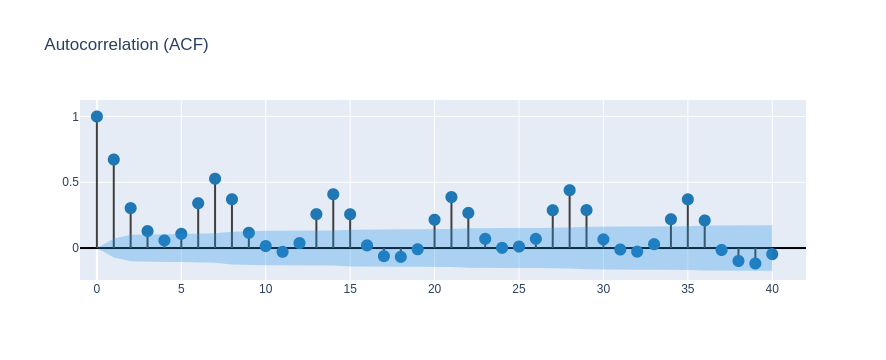

In [92]:
create_corr_plot(Exploration_series) #train['total_rides']

### Decomposing the Data

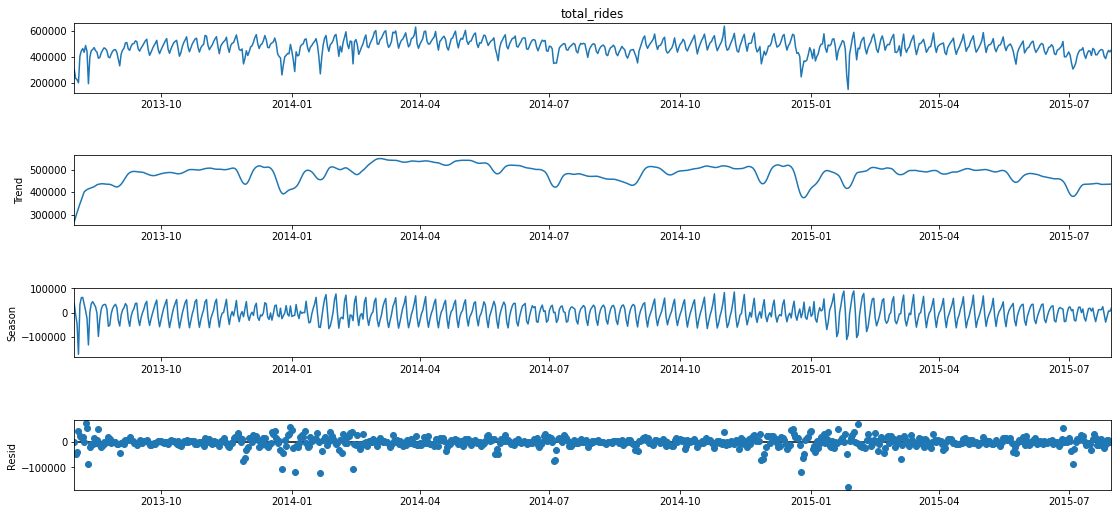

In [139]:
from statsmodels.tsa.seasonal import STL
import plotly.tools as tls 


stl = STL(endog=Exploration_series, seasonal=7)
res = stl.fit()
fig = res.plot()
fig.set_size_inches(18.5, 8)

In [150]:
pfig = tls.mpl_to_plotly(fig, resize=True)

In [151]:
type(pfig)

plotly.graph_objs._figure.Figure

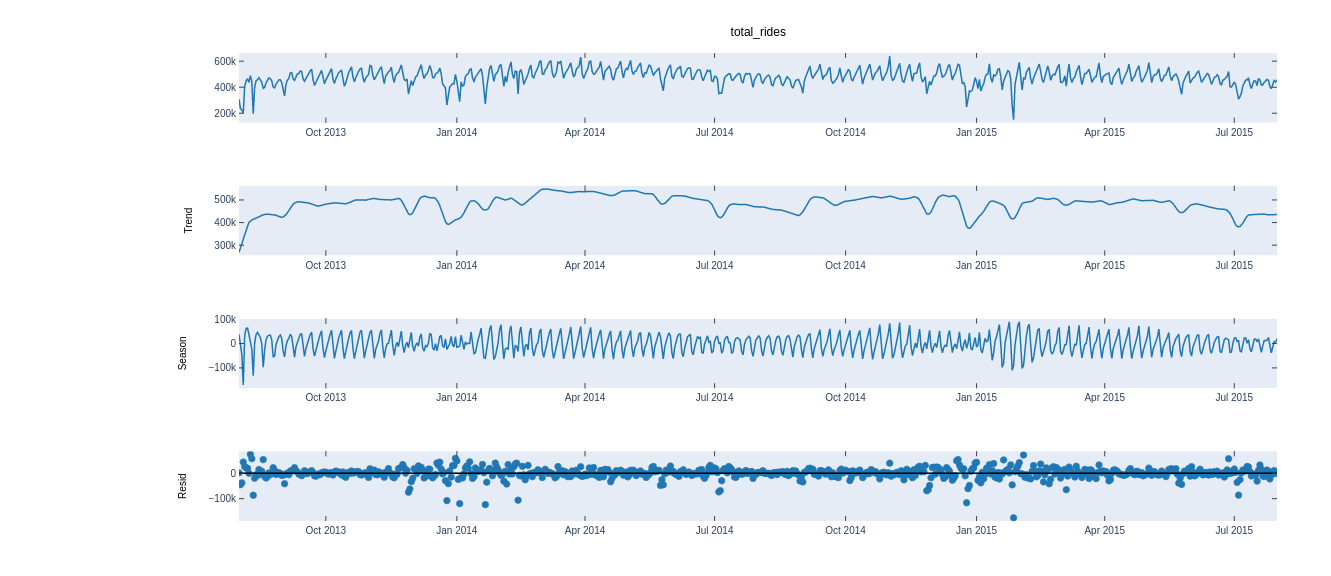

In [152]:
pfig.show(config={'responsive': True})